# Say Hello to Actor Critic

![좋은것](https://cdn-media-1.freecodecamp.org/images/1*e1N-YzQmJt-5KwUkdUvAHg.png)

[보면 좋은 것 1](https://rebornhugo.github.io/assets/images/post_images/Policy%20Gradient%20Methods/1522575360144.png)<br>
[나중에 보면 좋은 것](https://hal.inria.fr/hal-00840470/document)

1. Actor는 Policy를 만든다.
2. Critic은 현재 state의 가치(or 그 state에서의 action의 가치)를 평가한다


# 준비

In [1]:
%%time
## 약 25초 ~30초 소요
!pip install pyvirtualdisplay 
!apt-get install -y xvfb python-opengl ffmpeg
!pip install gym
!pip install box2d-py
#!pip install pyglet==1.3.2
!pip install pyglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 13 not upgraded.
Need to get 1,280 kB of archives.
After this operation, 7,686 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 1,280 kB in 1s (933 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 149406 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.8_amd64

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

In [3]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [4]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[-1]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# Acrobot-v1

In [5]:
env = wrap_env(gym.make("Acrobot-v1"))
print('observation space:', env.observation_space)
print('action space:', env.action_space)

state = env.reset()
for t in range(1000):
    action = env.action_space.sample() # your agent here (this takes random actions)
    env.render()
    observation, reward, done, info = env.step(action)
    if done: 
      break;
            
print('steps: ', t)
env.close()
show_video()

observation space: Box(-28.274333953857422, 28.274333953857422, (6,), float32)
action space: Discrete(3)
steps:  499


In [6]:
print("state 수는? : ", env.observation_space.shape)
print("action 수는? : ", env.action_space.n)

state 수는? :  (6,)
action 수는? :  3


# Actor Critic Network를 만들자!

1. 한 episode가 끝이 나야 학습이 진행이 되는 네트워크를 구성할 것이다.

In [7]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

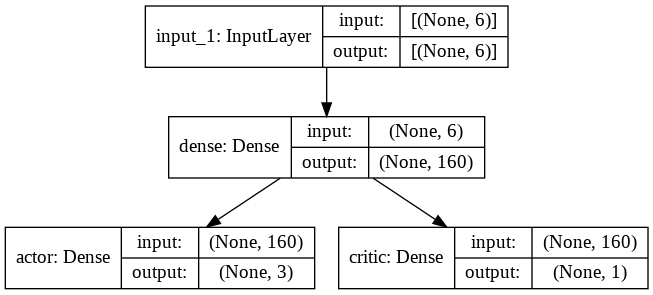

In [8]:
keras.backend.clear_session()

state_layer = layers.Input(shape=env.observation_space.shape)
common = layers.Dense(160, activation = 'relu')(state_layer)
action = layers.Dense(env.action_space.n, activation = 'softmax', name='actor')(common)
critic = layers.Dense(1, name='critic')(common)
model = keras.models.Model(inputs = state_layer, outputs=[action, critic])

plot_model(model, show_shapes=True)

# Compile

**두 가지의 loss를 알아야 한다.**
1. actor의 loss : return - critic_value와   actor(policy, actio확률들)의 crossentropy
    * .fit()에 넣어줄 output이 return - critic_value가 되는것!
2. critic의 loss : critic_value와 return의 huber loss!
    * .fit()에 넣어줄 output이 return이 되는 것!

In [9]:
adam = tf.keras.optimizers.Adam(0.01)
cce = tf.keras.losses.CategoricalCrossentropy(
    reduction=tf.keras.losses.Reduction.SUM)
huber = tf.keras.losses.Huber()

In [10]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.01),
              loss={'actor':cce, 'critic':huber})

# 한 Episode가 끝나면 학습을 시키는 방법!

**Return을 Normalize할 수 있다!**

## 일단 actor 네트워크를 믿고 한 에피소드에 필요한 내용들을 기록한다.

In [11]:
num_actions = env.action_space.n
state_history = []
action_history = []
critic_history = []
rewards_history = []

env = wrap_env(gym.make("Acrobot-v1"))
s0 = env.reset()
episode_reward = 0

for i in range(10000):
    s0 = s0.reshape([1,-1])
    state_history.append(s0)
    policy_s0, critic_s0 = model.predict(s0)
    critic_history.append(critic_s0[0,0])

    a0 = np.random.choice(num_actions, p = policy_s0.reshape(-1))
    a0_dummy = np.eye(num_actions)[a0]
    action_history.append(a0_dummy)
 
    s1, r1, done, _ = env.step(a0)
    rewards_history.append(r1)

    s0 = s1

    if done :
        env.close()
        # show_video()
        break

## return을 계산한다.
**Normalize를 하자!**

In [12]:
gamma = 0.99  # Discount factor for past rewards
num_inputs = 6
num_actions = 3
eps = np.finfo(np.float32).eps.item()  ## 매우 작은 수.

In [13]:
returns = []
Gt = 0
for r in rewards_history[::-1] : # 거꾸로 뽑는다.
    Gt = r + gamma*Gt
    returns.insert(0,  Gt) # append를 0번 인덱스부터 하는 것!

In [14]:
# Normalize
returns = np.array(returns)
returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
returns = returns.tolist()

## .fit()에 넣을 x, y를 준비한다.

1. state (x): [None, 4] 모양 주의
2. actor_r (y1): [None, 2] return-critic 과 action dummy 이용
3. critic_r (y2): [None, 1] return

In [15]:
state = np.vstack(state_history)
state.shape

(500, 6)

In [16]:
action_dummy = np.vstack(action_history)
returns = np.array(returns).reshape([-1,1])
critic = np.array(critic_history).reshape([-1,1])

action_dummy.shape, returns.shape, critic.shape

((500, 3), (500, 1), (500, 1))

In [17]:
actor_r = (returns-critic)*action_dummy
actor_r.shape

(500, 3)

## 한 에피소드로 학습을 시킨다.

In [18]:
model.fit(state, [actor_r, returns], verbose=0 ,epochs=1, batch_size=10000) # 한번에 학습을 하도록

## 이제 아래에 모아서 2000 episod 학습시켜보자! (중간에 중단 시킬 것)

=== 2번째 episode, rewards 합 : -500.0 ====
=== 4번째 episode, rewards 합 : -500.0 ====


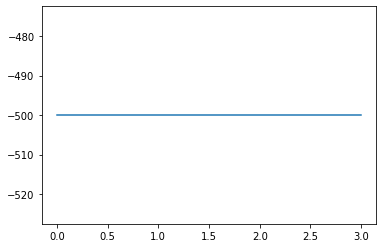

=== 6번째 episode, rewards 합 : -500.0 ====
=== 8번째 episode, rewards 합 : -500.0 ====


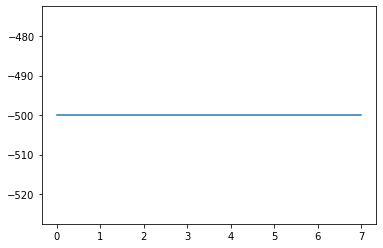

=== 10번째 episode, rewards 합 : -500.0 ====
=== 12번째 episode, rewards 합 : -500.0 ====


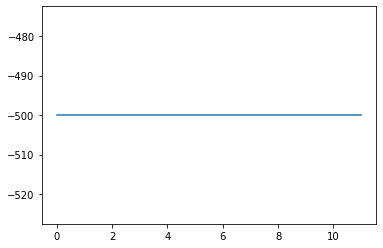

In [ ]:
n_episode = 2000
cum_r = []

for episode in range(n_episode):
    

    ### 한 episode 그대로 겪고 history를 남기도록.
    num_actions = env.action_space.n
    state_history = []
    action_history = []
    critic_history = []
    rewards_history = []

    env = wrap_env(gym.make("Acrobot-v1"))
    s0 = env.reset()
    episode_reward = 0

    for i in range(10000):
        s0 = s0.reshape([1,-1])
        state_history.append(s0)
        policy_s0, critic_s0 = model.predict(s0)
        critic_history.append(critic_s0[0,0])

        a0 = np.random.choice(num_actions, p = policy_s0.reshape(-1))
        a0_dummy = np.eye(num_actions)[a0]
        action_history.append(a0_dummy)
    
        s1, r1, done, _ = env.step(a0)
        rewards_history.append(r1)

        s0 = s1

        if done :
            env.close()
            cum_r.append(sum(rewards_history))
            # show_video()
            break

    ### 겪은 에피소드에서 학습되도록.
    returns = []
    Gt = 0
    for r in rewards_history[::-1] : # 거꾸로 뽑는다.
        Gt = r + gamma*Gt
        returns.insert(0,  Gt) # append를 0번 인덱스부터 하는 것!
    # Normalize
    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
    returns = returns.tolist()

    state = np.vstack(state_history)
    action_dummy = np.vstack(action_history)
    returns = np.array(returns).reshape([-1,1])
    critic = np.array(critic_history).reshape([-1,1])
    actor_r = (returns-critic)*action_dummy

    model.fit(state, [actor_r, returns], verbose=0 ,epochs=1, batch_size=10000) # 한번에 학습을 하도록

    if (episode+1) % 2 == 0 :
        print('=== {}번째 episode, rewards 합 : {} ===='.format(episode+1, cum_r[-1]))

    if (episode+1) % 4 == 0 :
        plt.plot(cum_r)
        plt.show()
        show_video()